# Análise estratégica para diminuição de desligamento (churn)

## Problema de negócio: 
A empresa de telecomunicações contratou a A3Data para avaliar o cenário de
churn elevado dos seus clientes e, uma vez que estamos falando de um produto
com custo elevado de setup (instalação), a empresa gostaria de uma estratégia
para reduzir esse churn.

### Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas_profiling import ProfileReport
import streamlit as st
from streamlit_pandas_profiling import st_profile_report
import dtale
import scipy.stats as ss
import warnings
warnings.filterwarnings('ignore')

C:\Users\leand\AppData\Local\Temp\ipykernel_9564\4123192654.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


### Carregamento da base de dados

In [2]:
df = pd.read_csv('Customer-Churn - Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"118,75","8672,45",No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,"118,65","8477,6",No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Mailed check,"118,6","7990,05",No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,"118,6","7365,7",No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),"118,35","7804,15",Yes


### Análise exploratória dos dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   int64 
 3   Partner           7043 non-null   object
 4   Dependents        7043 non-null   object
 5   tenure            7043 non-null   int64 
 6   PhoneService      7043 non-null   object
 7   MultipleLines     7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  Contract          7043 non-null   object
 16  PaperlessBilling  7043 non-null   object
 17  PaymentMethod 

In [4]:
# Converter variáveis numéricas strings em float
df['MonthlyCharges'] = df['MonthlyCharges'].str.replace(',', '.').astype(float)
df['TotalCharges'] = df['TotalCharges'].str.replace(',', '.').astype(float)

In [5]:
# Consultando linhas com valores ausentes
df_nulos = df.isnull().sum()
df_nulos

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

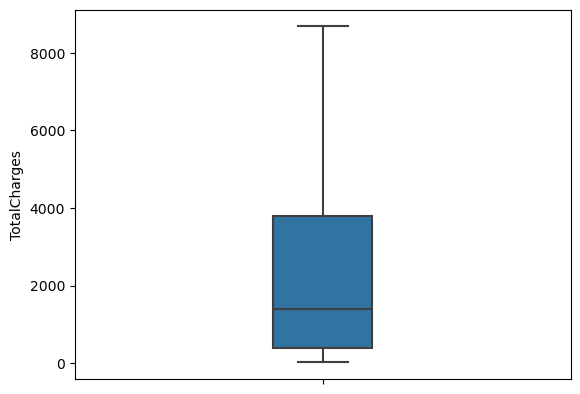

In [6]:
# Verificar se há outliers
sns.boxplot(y = df['TotalCharges'], width=0.2)
plt.show()

In [7]:
# Preencher valores nulos com a mediana
df['TotalCharges'].fillna(value = df['TotalCharges'].median(), inplace=True)

In [8]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
# Verificando se há dados duplicados
df_duplicados = df[df.duplicated()].sum()
df_duplicados

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges      0.0
TotalCharges        0.0
Churn                 0
dtype: object

In [10]:
# Análise estatística inicial
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [11]:
### Analisando a correlação das colunas com valores numéricos da base de dados
df_corr = df[['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']].corr('spearman')

In [12]:
# Normalização dos dados para análise da correlação
df_min_max_scaled = df_corr.copy()

for column in df_min_max_scaled.columns: 
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())     
df_min_max_scaled

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.000000,0.000000,0.000000
tenure,0.000000,1.000000,0.071059,0.873422
MonthlyCharges,0.206340,0.262736,1.000000,0.593921
TotalCharges,0.090377,0.884861,0.534588,1.000000


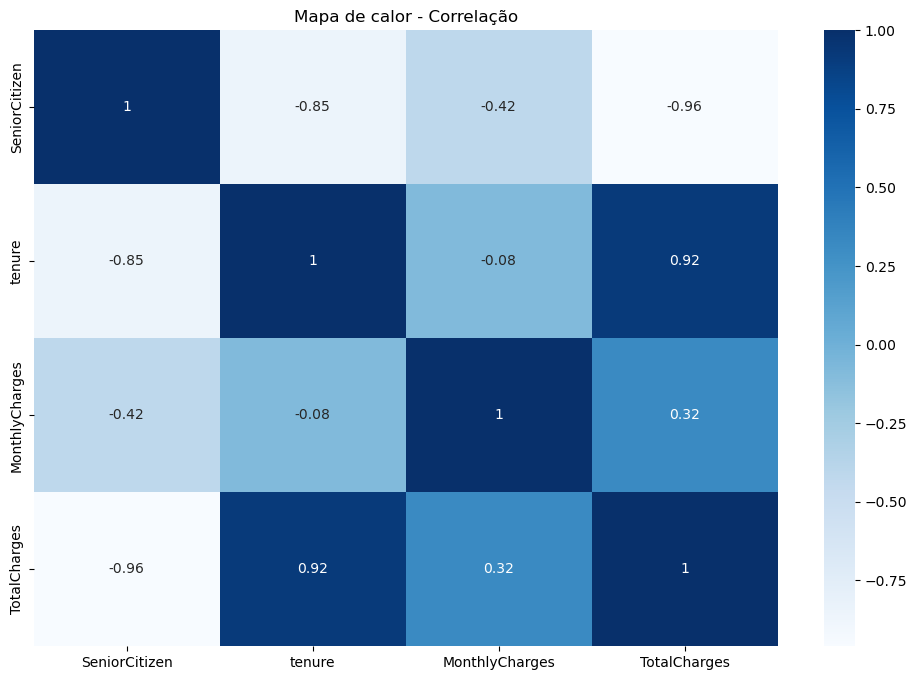

In [13]:
corr_df = df_min_max_scaled.corr(method='pearson').round(2)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, cmap='Blues')
plt.title('Mapa de calor - Correlação')
plt.savefig('mapa_de_calor_indices.png', dpi = 300)
plt.show()

In [14]:
# Análise da distribuição por classes em função do Churn por valores únicos
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [15]:
# Distribuição percentual por classes
df_porcentual = round(df['Churn'].value_counts() / df.shape[0] * 100, 3)
df_porcentual

Churn
No     73.463
Yes    26.537
Name: count, dtype: float64

In [16]:
# Quantidade de dados distribuidos por classes
df.gender.value_counts()

gender
Male      3555
Female    3488
Name: count, dtype: int64

### Análise visual de cancelamento por tipo de gênero e contrato

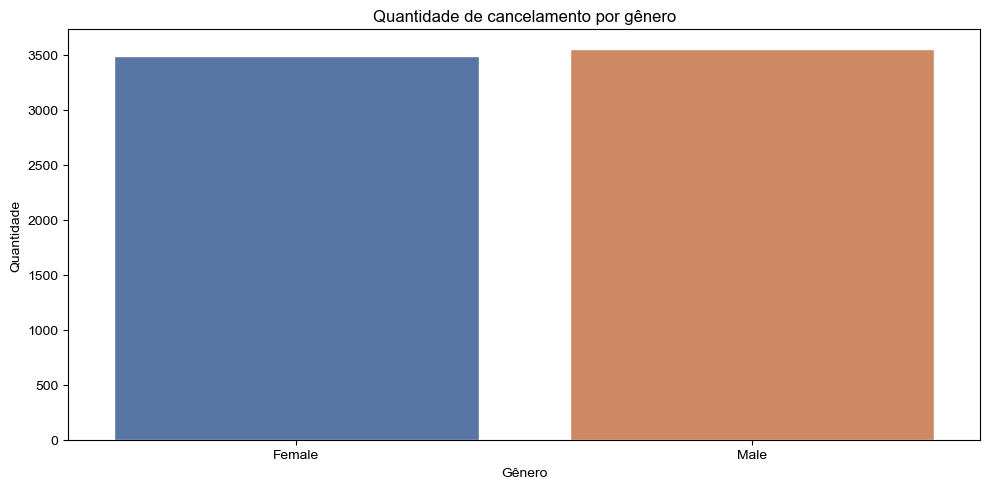

In [17]:
# Análise visual da quantidade de cancelamento por gênero
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['red', 'blue']
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("deep"))
count = df['gender'].loc[df.Churn == 'Yes'].value_counts()
sns.countplot(x='gender', data=df)
ax.set_xlabel('Gênero')
ax.set_ylabel('Quantidade')
ax.set_title('Quantidade de cancelamento por gênero');
plt.tight_layout()

In [18]:
# Análise do cancelamento por tipo de contrato
df.Contract.loc[df.Churn == 'Yes'].value_counts()/df.Contract.value_counts() * 100

Contract
Month-to-month    42.709677
One year          11.269518
Two year           2.831858
Name: count, dtype: float64

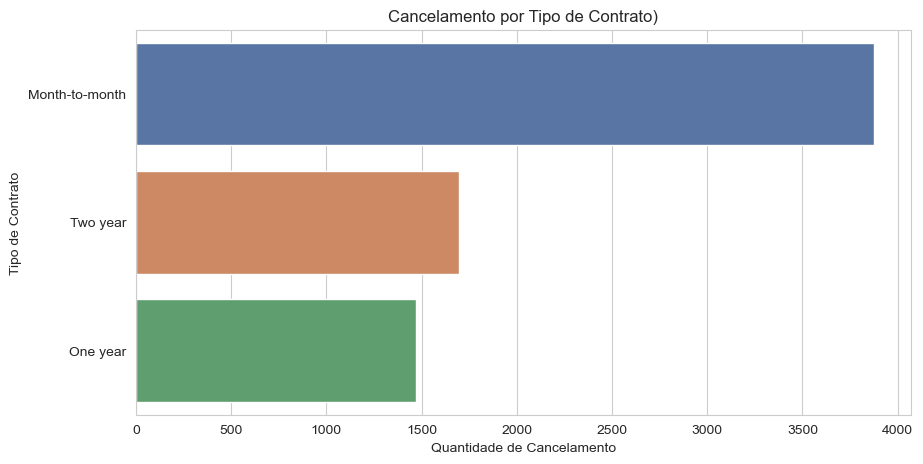

In [19]:
# Análise visual do cancelamento por tipo de contrato
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.set(style="whitegrid")
sns.set_palette(sns.color_palette("deep"))
ax = sns.barplot(x=list(df.Contract.value_counts().values), y=list(df.Contract.value_counts().index), order= df.Contract.value_counts().sort_values(ascending = False).index, ax = ax)
ax.set_xlabel('Quantidade de Cancelamento')
ax.set_ylabel('Tipo de Contrato')
ax.set_title("Cancelamento por Tipo de Contrato)");

### EDA usando Pandas_profiling e Dtale

In [20]:
# Aplicando o pandas profiling
profile = ProfileReport(df, title="EDA - Churn")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
'''# Fazendo deploy do EDA obtido pelo pandas_profiling
st.title("Análise para estratégia de Churn!")

st.write(df)

st_profile_report(profile)'''

In [21]:
# Aplicando o D-tale  - 2a opção
d = dtale.show(df, open_brownse=False) #True: para deploy
d

### Análise estatística aplicando o teste de hipótese envolvendo contratos mensais

In [22]:
# Criar uma tabela de contingência com tipo de contrato e o churn
tabela_contingência = pd.crosstab(df['Churn'], df['Contract'])

# Execute o teste de Qui-Quadrado
chi2, p_valor, _, valor_esperado = ss.chi2_contingency(tabela_contingência)

print(f"Valor de Qui-Quadrado: {chi2}")
print(f"p-valor: {p_valor}")

# Calcule os residuais padronizados
valor_residual = (tabela_contingência - valor_esperado) / valor_esperado**0.5

print(valor_residual)

Valor de Qui-Quadrado: 1184.5965720837926
p-valor: 5.863038300673391e-258
Contract  Month-to-month   One year   Two year
Churn                                         
No            -11.745831   6.836504  11.386567
Yes            19.543049 -11.374770 -18.945295


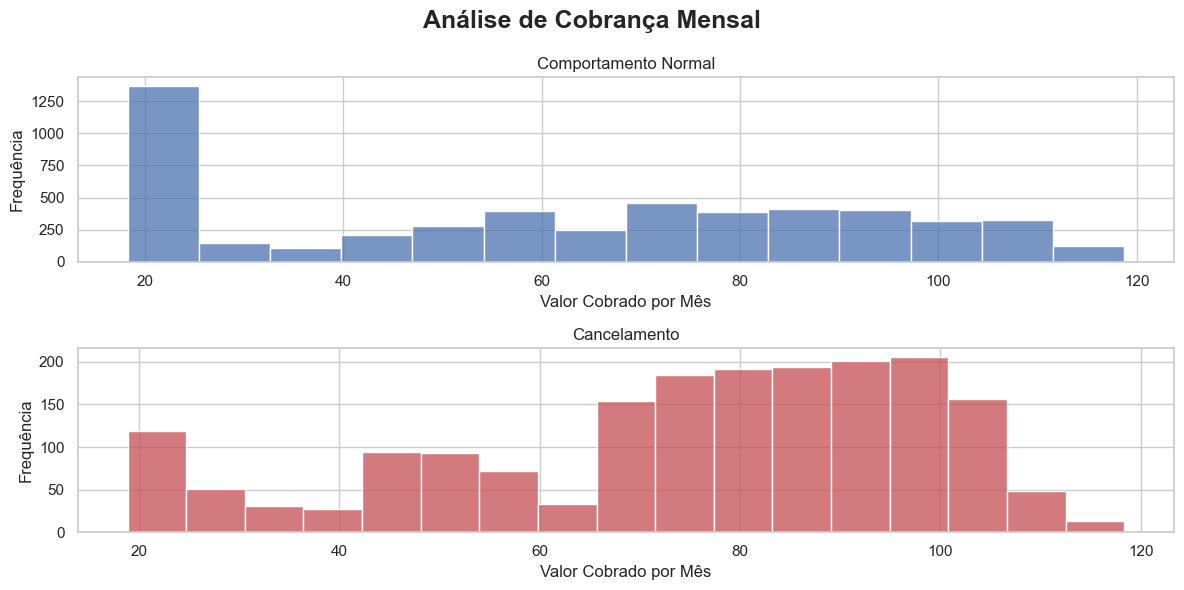

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("deep"))
sns.histplot(data=df.MonthlyCharges.loc[df.Churn == 'No'], kde=False, ax = ax[0], color=sns.color_palette()[0])
sns.histplot(data=df.MonthlyCharges.loc[df.Churn == 'Yes'], kde=False, ax = ax[1], color=sns.color_palette()[3])
ax[0].set_xlabel('Valor Cobrado por Mês')
ax[0].set_ylabel('Frequência')
ax[0].set_title('Comportamento Normal');

ax[1].set_xlabel('Valor Cobrado por Mês')
ax[1].set_ylabel('Frequência')
ax[1].set_title('Cancelamento');

fig.suptitle("Análise de Cobrança Mensal", fontsize=18, fontweight='bold')
plt.tight_layout()

In [24]:
print("Variância da Normal:",df.MonthlyCharges.loc[df.Churn == 'No'].var())
print("Variância do desligamento (Churn):", df.MonthlyCharges.loc[df.Churn == 'Yes'].var())

Variância da Normal: 966.7527670734413
Variância do desligamento (Churn): 608.4141833954309


In [25]:
X = df.MonthlyCharges.loc[df.Churn == 'No']
Y = df.MonthlyCharges.loc[df.Churn == 'Yes']
df1 = len(X) - 1
df2 = len(Y) - 1
F = X.var() / Y.var()
alpha = 0.05
p_value = 1 - ss.f.cdf(F, df1, df2)
print("P-valor:", p_value)

P-valor: 1.1102230246251565e-16


In [26]:
print("Média Normal:",df.MonthlyCharges.loc[df.Churn == 'No'].mean())
print("Média do Desligamento (Churn):", df.MonthlyCharges.loc[df.Churn == 'Yes'].mean())

Média Normal: 61.26512369540008
Média do Desligamento (Churn): 74.44133226324237


In [27]:
X = df.MonthlyCharges.loc[df.Churn == 'No']
Y = df.MonthlyCharges.loc[df.Churn == 'Yes']
ss.ttest_ind(a=X, b=Y, equal_var=False)

Ttest_indResult(statistic=-18.407526676414673, pvalue=8.59244933154705e-73)

## Construção do baseline e da máquina preditiva

### Definição do modelo mais adequado para a máquina preditiva

In [28]:
# Importação das bibliotecas para o machine learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.metrics import roc_auc_score, roc_curve
from collections import defaultdict

### Separando os dados para treino e teste

In [29]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [30]:
# Convertendo as variáveis para inteiros 0 e 1.
y = pd.Series(np.where(y.values == 'Yes', 1, 0), y.index)
y.value_counts()

0    5174
1    1869
Name: count, dtype: int64

In [31]:
# Verificando as colunas com informações categóricas
colunas_categoricas = [col for col in X.select_dtypes(exclude='number').columns]
colunas_categoricas

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

### Aplicando o Label Enconder para conversão

In [32]:
# Encoding da base de dados
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

# Armazenando o dicionário de dados
label_dict = defaultdict(LabelEncoder)

# fit do enconder
label = LabelEncoder()
X = X.apply(lambda i: label_dict[i.name].fit_transform(i))

In [33]:
X.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,5360,0,0,1,1,72,1,2,1,2,2,2,2,2,2,2,1,0,1584,6529
1,6345,0,0,0,0,71,1,2,1,2,2,2,2,2,2,2,1,2,1583,6520
2,4247,0,0,1,0,68,1,2,1,2,2,2,2,2,2,2,0,3,1582,6450
3,4067,0,0,0,0,61,1,2,1,2,2,2,2,2,2,1,1,2,1582,6307
4,5824,1,0,0,0,67,1,2,1,2,2,2,2,2,2,1,1,0,1581,6406


In [34]:
# Identificar variáveis numéricas
col_numb = [col for col in X.select_dtypes(['int', 'float']).columns.tolist() if col not in colunas_categoricas]

# como convertemos para colunas dummies iremos identificar novamente as colunas com apenas dois valores
col_dummies = X.nunique()[X.nunique() == 2].keys().tolist()

# Identificar colunas com mais de uma categoria
val_cate = [col for col in X.columns.tolist() if col not in col_dummies + col_numb]

In [35]:
val_cate

['customerID',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [36]:
# Convertendo as variáveis numéricas para colunas numéricas
X = pd.get_dummies(X, columns = val_cate)

In [37]:
X.fillna(X.mean(), inplace=True)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [39]:
# Padronização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [40]:
#armazenando o dicionário de dados
label_dict = defaultdict(LabelEncoder)

#fit do enconder
label = LabelEncoder()
X = X.apply(lambda i: label_dict[i.name].fit_transform(i))

In [41]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,customerID_0,...,StreamingMovies_0,StreamingMovies_1,StreamingMovies_2,Contract_0,Contract_1,Contract_2,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3
0,0,0,1,1,72,1,1,1584,6529,0,...,0,0,1,0,0,1,1,0,0,0
1,0,0,0,0,71,1,1,1583,6520,0,...,0,0,1,0,0,1,0,0,1,0
2,0,0,1,0,68,1,0,1582,6450,0,...,0,0,1,0,0,1,0,0,0,1
3,0,0,0,0,61,1,1,1582,6307,0,...,0,0,1,0,1,0,0,0,1,0
4,1,0,0,0,67,1,1,1581,6406,0,...,0,0,1,0,1,0,1,0,0,0


In [42]:
# Variáveis criadas para testar a performance de diferentes modelos de machine learning
model_xgbc = XGBClassifier()
model_sgd = SGDClassifier()
model_svc = SVC()
model_lr = LogisticRegression()
model_dt = DecisionTreeClassifier()
voting_clf = VotingClassifier(estimators =[('xgbc', model_xgbc), ('sgd', model_sgd), ('svc', model_svc), ('dt', model_dt), ('lr', model_lr)], voting='hard')

In [43]:
# Fit do modelo
for model in (model_xgbc, model_sgd, model_svc, model_dt,model_lr, voting_clf):
  model.fit(X_train_scaled, y_train)

# Fazer previsões em cima dos dados
model = []
accuracy = []

for clf in (model_xgbc, model_sgd, model_svc, model_dt, model_lr, voting_clf):
  y_pred = clf.predict(X_test_scaled)
  model.append(clf.__class__.__name__)
  accuracy.append(accuracy_score(y_test,y_pred))

# Verifcando Acurácia dos modelos
col = ['Acuracia']
ac = pd.DataFrame(data=accuracy, index=model, columns=col)
ac

,Acuracia
XGBClassifier,0.772288
SGDClassifier,0.796139
SVC,0.789892
DecisionTreeClassifier,0.764338
LogisticRegression,0.788756
VotingClassifier,0.791028


### Validação cruzada

In [44]:
# Aplicando Validação Cruzada com K-Fold
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = voting_clf, X = X_train_scaled, y = y_train, cv = 10, verbose=3)
print("Acurácia: {:.2f} %".format(accuracies.mean()*100))

[CV] END ................................ score: (test=0.784) total time= 4.3min
[CV] END ................................ score: (test=0.788) total time= 4.2min
[CV] END ................................ score: (test=0.820) total time= 4.5min
[CV] END ................................ score: (test=0.795) total time= 4.3min
[CV] END ................................ score: (test=0.814) total time= 4.3min
[CV] END ................................ score: (test=0.809) total time= 4.1min
[CV] END ................................ score: (test=0.769) total time= 4.0min
[CV] END ................................ score: (test=0.792) total time= 4.0min
[CV] END ................................ score: (test=0.805) total time= 4.0min


2023-10-09 09:45:48,118 - INFO     - Executing shutdown due to inactivity...
2023-10-09 09:46:04,432 - INFO     - Executing shutdown...
2023-10-09 09:46:04,440 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer
2023-10-09 09:46:04,894 - ERROR    - weakly-referenced object no longer exists
2023-10-09 09:46:04,947 - ERROR    - weakly-referenced object no longer exists
2023-10-09 09:46:04,955 - ERROR    - weakly-referenced object no longer exists


[CV] END ................................ score: (test=0.818) total time= 4.0min
Acurácia: 79.95 %


### Modelo Baseline

In [45]:
# Dividir dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Padronização os dados
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Rebalanceamento dos dados
from imblearn.under_sampling import RandomUnderSampler;
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1293
           1       0.52      0.78      0.62       468

    accuracy                           0.75      1761
   macro avg       0.71      0.76      0.72      1761
weighted avg       0.80      0.75      0.76      1761

AUC: 0.7580



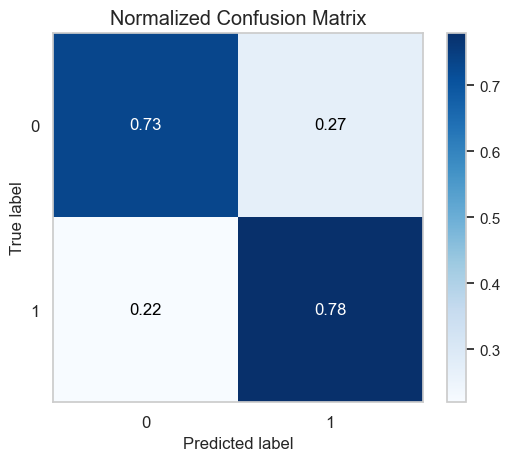

In [46]:
# Modelo baseline com ajustes nos hiperparâmetros
modelo_final = XGBClassifier(learning_rate= 0.2700390206185342, n_estimators= 83, max_delta_step = 18,
                             max_depth= 36, min_child_weight= 2, gamma= 3.811128976537413e-05, 
                             colsample_bylevel = 0.8015579071911014, colsample_bytree = 0.44364889457651413,
                             reg_lambda= 659, reg_alpha= 1.5057560255472018e-06)

modelo_final.fit(X_train_rus, y_train_rus)

# Fazer a predição
X_test = scaler.transform(X_test)
y_pred = modelo_final.predict(X_test)

# Classificação
print(classification_report(y_test, y_pred))

# Valor da área sob a curva ROC
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# Matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

In [47]:
# Importando a bibliteca pickle para salvar o modelo e fazer o posterior deploy
import pickle

# Salvando o modelo de ML treinado
pickle.dump(modelo_final, open('modelo_final.pkl','wb'))

In [48]:
# Importando a bibliteca joblib para salvar o modelo e fazer o posterior deploy
from joblib import dump, load

# Salvando o modelo de ML treinado
dump(modelo_final, 'modelo_final.joblib')

['modelo_final.joblib']